In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../data')
from process_data import process_data
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
import random
import re

# Base Data

In [3]:
# pull in train and test datasets
X_train, y_train, X_test, y_test = process_data(buckets = 10)

# NSFW Data

In [4]:
# Add nsfw column to test data
nsfw_scores = pd.read_csv('../data/nsfw_scores.csv')
nsfw_scores.drop(columns = ['Unnamed: 0'], inplace = True)
nsfw_scores.rename(columns = {'video_ids': 'video_id'}, inplace = True)

X_train = pd.merge(X_train, nsfw_scores, on = 'video_id', how = 'left')
X_test = pd.merge(X_test, nsfw_scores, on = 'video_id', how = 'left')

nsfw_scores

,video_id,nsfw_scores
0,rpe5kB2eGvo,0.0171
1,MvuqM_9h6QY,0.0925
2,ZcGlf7EZ-vU,0.0443
3,hDk1ne5TCHM,0.0005
4,-X0eQXFbTQo,0.0002
...,...,...
2319,A7cWtICGgHE,0.0082
2320,d-HPZL6AU64,0.0033
2321,UfwXf7AisAs,0.1110
2322,LqmmjHEyiHM,0.0135


# Image Labeling Data

In [5]:
# Helper function
import nltk
from nltk.corpus import wordnet

categories = ['person', 'vehicle', 'object', 'animal', 'sport', 'food', 'furniture', 'electronic', 'appliance', 'other']

def categorize_words(words):
    word_categories = {}
    for word in words:
        synsets = wordnet.synsets(word)
        if len(synsets) == 0:
            word_categories[word] = 'other'
        else:
            # Get the first synset
            synset = synsets[0]
            # Traverse the hypernym hierarchy to find a category
            hypernyms = synset.hypernyms()
            category_found = False
            while hypernyms and not category_found:
                hypernym = hypernyms[0]
                hypernym_name = hypernym.name()
                for category in categories:
                    if category in hypernym_name:
                        word_categories[word] = category
                        category_found = True
                        break
                hypernyms = hypernym.hypernyms()
            if not category_found:
                word_categories[word] = 'other'
    return word_categories

def categorize_words_column(df, column):
    words = df[column].astype(str).unique()
    word_to_category = categorize_words(words)

    # add a new column to Xception_label_df that maps label_1 values to categories
    df[column] = df[column].astype(str).map(word_to_category)
    
    return df

In [6]:
# Add vgg16 column to test data
vgg16_label_df = pd.read_csv('../data/vgg16.csv', index_col=0)

categorize_words_column(vgg16_label_df, 'label_1')
categorize_words_column(vgg16_label_df, 'label_2')
categorize_words_column(vgg16_label_df, 'label_3')

vgg16_label_df.rename(columns = {'label_1': 'vgg16_label_1', 'label_2': 'vgg16_label_2', 'label_3': 'vgg16_label_3'}, inplace = True)

X_train = pd.merge(X_train, vgg16_label_df, on = 'video_id', how = 'left')
X_test = pd.merge(X_test, vgg16_label_df, on = 'video_id', how = 'left')

vgg16_label_df

,video_id,vgg16_label_1,vgg16_label_2,vgg16_label_3
0,rpe5kB2eGvo,other,object,animal
1,MvuqM_9h6QY,object,other,object
2,ZcGlf7EZ-vU,other,object,object
3,hDk1ne5TCHM,object,object,object
4,-X0eQXFbTQo,object,object,other
...,...,...,...,...
2319,A7cWtICGgHE,object,other,object
2320,d-HPZL6AU64,object,object,object
2321,UfwXf7AisAs,object,object,other
2322,LqmmjHEyiHM,object,object,object


In [7]:
# Add Xception column to test data
Xception_label_df = pd.read_csv('../data/Xception.csv', index_col=0)

categorize_words_column(Xception_label_df, 'label_1')
categorize_words_column(Xception_label_df, 'label_2')
categorize_words_column(Xception_label_df, 'label_3')

Xception_label_df.rename(columns = {'label_1': 'Xception_label_1', 'label_2': 'Xception_label_2', 'label_3': 'Xception_label_3'}, inplace = True)

X_train = pd.merge(X_train, Xception_label_df, on = 'video_id', how = 'left')
X_test = pd.merge(X_test, Xception_label_df, on = 'video_id', how = 'left')

Xception_label_df

,video_id,Xception_label_1,Xception_label_2,Xception_label_3
0,rpe5kB2eGvo,animal,person,object
1,MvuqM_9h6QY,object,object,object
2,ZcGlf7EZ-vU,object,object,object
3,hDk1ne5TCHM,sport,animal,other
4,-X0eQXFbTQo,object,object,object
...,...,...,...,...
2319,A7cWtICGgHE,object,object,sport
2320,d-HPZL6AU64,object,object,object
2321,UfwXf7AisAs,vehicle,object,object
2322,LqmmjHEyiHM,animal,object,animal


In [8]:
# Add YOLOv3 column to test data
YOLOv3_label_df = pd.read_csv('../data/YOLOv3.csv', index_col=0)

categorize_words_column(YOLOv3_label_df, 'label_1')
categorize_words_column(YOLOv3_label_df, 'label_2')
categorize_words_column(YOLOv3_label_df, 'label_3')

YOLOv3_label_df.rename(columns = {'label_1': 'YOLOv3_label_1', 'label_2': 'YOLOv3_label_2', 'label_3': 'YOLOv3_label_3'}, inplace = True)

X_train = pd.merge(X_train, YOLOv3_label_df, on = 'video_id', how = 'left')
X_test = pd.merge(X_test, YOLOv3_label_df, on = 'video_id', how = 'left')

YOLOv3_label_df

,video_id,YOLOv3_label_1,YOLOv3_label_2,YOLOv3_label_3
0,rpe5kB2eGvo,person,person,person
1,MvuqM_9h6QY,vehicle,person,person
2,ZcGlf7EZ-vU,vehicle,other,other
3,hDk1ne5TCHM,person,person,person
4,-X0eQXFbTQo,person,person,person
...,...,...,...,...
2319,A7cWtICGgHE,other,person,person
2320,d-HPZL6AU64,vehicle,person,person
2321,UfwXf7AisAs,person,person,person
2322,LqmmjHEyiHM,vehicle,sport,person


# Preprocess text content

In [9]:
import nltk
from nltk.corpus import stopwords

def clean_text(text):
    """Function to clean up text by making all characters lowercase,
    removing non-alphanumeric characters, and removing common stop words"""

    # make the text lowercase
    text = text.lower()
    
    # remove URLs
    text = re.sub("https?[^\s]+", ' ', text)

    # remove non-alphabetic characters (including digits and punctuation)
    text = re.sub("[^a-zA-Z\s]", ' ', text)
    
    # remove single character words
    text = re.sub("\s[a-zA-Z]{1}\s", ' ', text)
    
    # remove excess white space
    text = re.sub("[ \t]{2,}", ' ', text)

    # remove common stop words
    stop_words = set(stopwords.words("english"))
    text = [w for w in text.split() if w not in stop_words]

    return " ".join(text)

X_train['description'] = X_train['description'].apply(clean_text)
X_test['description'] = X_test['description'].apply(clean_text)
X_train['title'] = X_train['title'].apply(clean_text)
X_test['title'] = X_test['title'].apply(clean_text)

X_train['description'] = X_train['description'].astype(str)
X_test['description'] = X_test['description'].astype(str)
X_train['title'] = X_train['title'].astype(str)
X_test['title'] = X_test['title'].astype(str)

X_train[['title','description']]

,title,description
0,filthiest dunks nba history,best dunks nba history let know make part than...
1,rating every american cereal ludwig abroad japan,ultimate tier list different cereal could find...
2,easiest hardest countries take,world filled dominating military forces around...
3,vs hotel room,hotel end worth wait download experian app vis...
4,mayweather vs paul ceremonial weigh showtime ppv,hall fame boxing legend floyd mayweather socia...
...,...,...
1854,elden ring official dlc miquella dream confirm...,dlc finally revealed elden ring shadow erdtree...
1855,kirby tier list,kirby triple deluxe finally opinion thank note...
1856,latest march pinoy boxer mercy tinalo ang form...,latest march pinoy boxer mercy tinalo ang form...
1857,harry styles,lyrics holdin back gravity holdin back want ho...


In [10]:
# Show column types of X_train
X_train.dtypes

video_id                                  object
title                                     object
description                               object
video_published_at           datetime64[ns, UTC]
num_tags                                 float64
channel                                   object
channel_id                                object
thumbnail_url                             object
duration                                 float64
definition                                object
caption                                     bool
channel_description                       object
channel_published_at         datetime64[ns, UTC]
days_published_channel                   float64
channel_videos                           float64
likes_to_views                           float64
comments_to_views                        float64
log_hours_published_video                float64
log_channel_subscribers                  float64
nsfw_scores                              float64
vgg16_label_1       

In [11]:
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import StackingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from mlxtend.feature_selection import ColumnSelector

# Select columns to be used in the model
data_columns = [
    "num_tags",
    "duration",
    "caption",
    "channel_videos",
    "likes_to_views",
    "comments_to_views",
    "log_hours_published_video",
    "log_channel_subscribers",
]
data_num_columns = make_column_selector(pattern="|".join(data_columns), dtype_include=["int64", "float64", "bool"])
data_cat_columns = make_column_selector(pattern="|".join(data_columns), dtype_include=["object"])

image_columns = [
    "nsfw_scores",
    "vgg16_label_1",
    "vgg16_label_2",
    "vgg16_label_3",
    "Xception_label_1",
    "Xception_label_2",
    "Xception_label_3",
    "YOLOv3_label_1",
    "YOLOv3_label_2",
    "YOLOv3_label_3",
]
image_num_columns = make_column_selector(pattern="|".join(image_columns), dtype_include=["int64", "float64", "bool"])
image_cat_columns = make_column_selector(pattern="|".join(image_columns), dtype_include=["object"])

basic_column_transformer = make_column_transformer(
    ("passthrough", data_num_columns),
    (OrdinalEncoder(), data_cat_columns)
)

images_column_transformer = make_column_transformer(
    ("passthrough", data_num_columns),
    (OrdinalEncoder(), data_cat_columns),
    ("passthrough", image_num_columns),
    (OrdinalEncoder(), image_cat_columns)
)

title_column_transformer = make_column_transformer(
    ("passthrough", make_column_selector(pattern="title")),
)
description_column_transformer = make_column_transformer(
    ("passthrough", make_column_selector(pattern="description")),
)


def evaluate(model):
    # Train the model on the training data
    model.fit(X_train, y_train['views_category_10'])

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred)

    print("Classification Report:\n", cr)

    print("Confusion Matrix:\n")
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.76      0.72        51
          10       0.29      0.41      0.34        44
          20       0.17      0.12      0.14        58
          30       0.23      0.25      0.24        32
          40       0.35      0.22      0.27        54
          50       0.17      0.26      0.20        35
          60       0.17      0.17      0.17        40
          70       0.42      0.28      0.34        57
          80       0.46      0.59      0.51        44
          90       0.67      0.58      0.62        50

    accuracy                           0.37       465
   macro avg       0.36      0.37      0.36       465
weighted avg       0.37      0.37      0.36       465

Confusion Matrix:



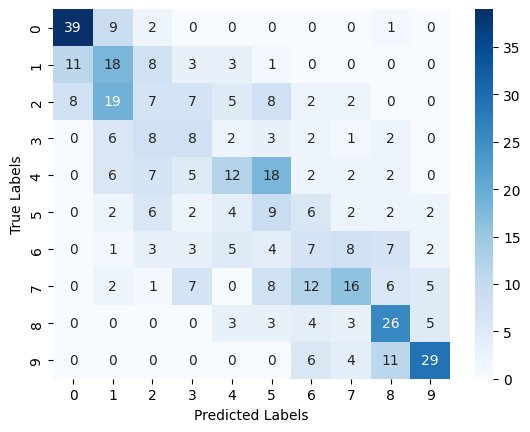

In [12]:
model_gradient_boosting = make_pipeline(basic_column_transformer, GradientBoostingClassifier())
evaluate(model_gradient_boosting)

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.75      0.70        51
          10       0.26      0.39      0.31        44
          20       0.21      0.14      0.16        58
          30       0.26      0.28      0.27        32
          40       0.40      0.30      0.34        54
          50       0.11      0.17      0.13        35
          60       0.10      0.10      0.10        40
          70       0.29      0.18      0.22        57
          80       0.41      0.55      0.47        44
          90       0.68      0.56      0.62        50

    accuracy                           0.34       465
   macro avg       0.34      0.34      0.33       465
weighted avg       0.35      0.34      0.34       465

Confusion Matrix:



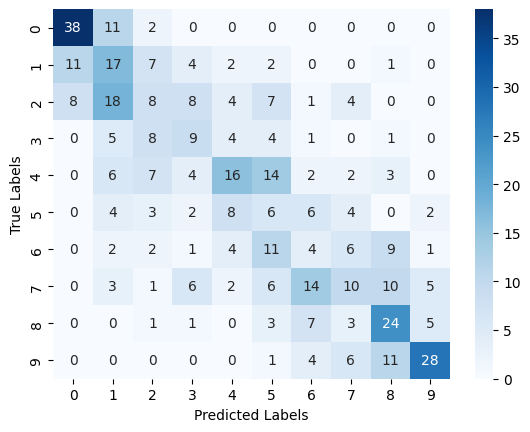

In [13]:
model_gradient_boosting_images = make_pipeline(images_column_transformer, GradientBoostingClassifier())
evaluate(model_gradient_boosting_images)

Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.67      0.61        51
          10       0.23      0.36      0.28        44
          20       0.25      0.16      0.19        58
          30       0.19      0.22      0.21        32
          40       0.43      0.28      0.34        54
          50       0.15      0.26      0.19        35
          60       0.22      0.17      0.19        40
          70       0.36      0.21      0.27        57
          80       0.46      0.59      0.51        44
          90       0.72      0.68      0.70        50

    accuracy                           0.36       465
   macro avg       0.36      0.36      0.35       465
weighted avg       0.37      0.36      0.36       465

Confusion Matrix:



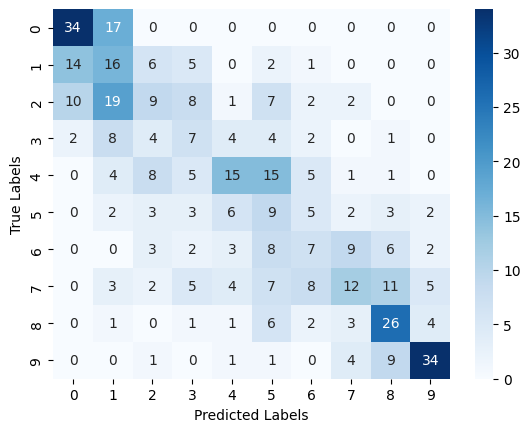

In [14]:
model_random_forest = make_pipeline(basic_column_transformer, RandomForestClassifier())
evaluate(model_random_forest)

Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.78      0.68        51
          10       0.29      0.39      0.33        44
          20       0.27      0.17      0.21        58
          30       0.13      0.16      0.14        32
          40       0.41      0.24      0.30        54
          50       0.11      0.20      0.14        35
          60       0.19      0.17      0.18        40
          70       0.38      0.21      0.27        57
          80       0.45      0.57      0.50        44
          90       0.67      0.62      0.65        50

    accuracy                           0.36       465
   macro avg       0.35      0.35      0.34       465
weighted avg       0.37      0.36      0.35       465

Confusion Matrix:



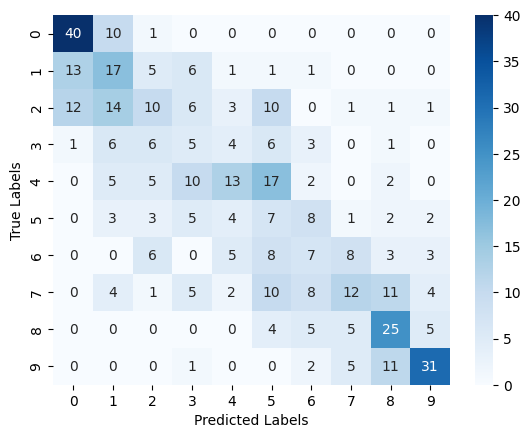

In [15]:
model_random_forest_images = make_pipeline(images_column_transformer, RandomForestClassifier())
evaluate(model_random_forest_images)

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.75      0.71        51
          10       0.28      0.48      0.36        44
          20       0.17      0.05      0.08        58
          30       0.18      0.25      0.21        32
          40       0.42      0.33      0.37        54
          50       0.27      0.34      0.30        35
          60       0.22      0.30      0.26        40
          70       0.40      0.14      0.21        57
          80       0.41      0.59      0.49        44
          90       0.68      0.64      0.66        50

    accuracy                           0.38       465
   macro avg       0.37      0.39      0.36       465
weighted avg       0.38      0.38      0.37       465

Confusion Matrix:



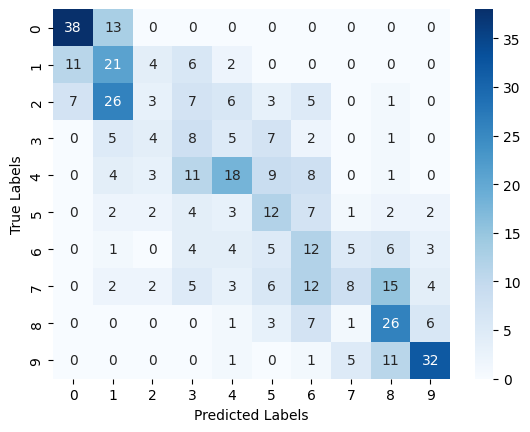

In [16]:
model_ensemble_basic = StackingClassifier(
    estimators=[
        ('gb', model_gradient_boosting),
        ('rf', model_random_forest)
    ],
    final_estimator=LogisticRegression()
)

evaluate(model_ensemble_basic)

Classification Report:
               precision    recall  f1-score   support

           0       0.31      0.20      0.24        51
          10       0.22      0.23      0.22        44
          20       0.11      0.05      0.07        58
          30       0.10      0.25      0.14        32
          40       0.27      0.15      0.19        54
          50       0.10      0.20      0.13        35
          60       0.15      0.20      0.17        40
          70       0.13      0.05      0.07        57
          80       0.17      0.18      0.18        44
          90       0.26      0.26      0.26        50

    accuracy                           0.17       465
   macro avg       0.18      0.18      0.17       465
weighted avg       0.19      0.17      0.17       465

Confusion Matrix:



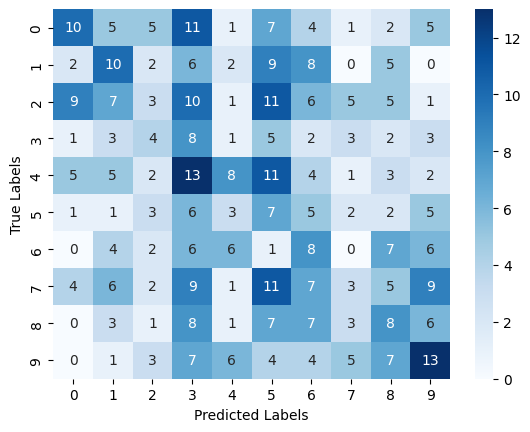

In [17]:
model_title_bow = make_pipeline(
    ColumnSelector(cols=('title'), drop_axis=True),
    CountVectorizer(),
    TfidfTransformer(),
    LogisticRegression()
)
evaluate(model_title_bow)

Classification Report:
               precision    recall  f1-score   support

           0       0.23      0.27      0.25        51
          10       0.18      0.20      0.19        44
          20       0.21      0.10      0.14        58
          30       0.11      0.19      0.13        32
          40       0.31      0.17      0.22        54
          50       0.09      0.17      0.12        35
          60       0.14      0.17      0.16        40
          70       0.15      0.07      0.10        57
          80       0.38      0.45      0.42        44
          90       0.64      0.54      0.59        50

    accuracy                           0.23       465
   macro avg       0.24      0.23      0.23       465
weighted avg       0.25      0.23      0.23       465

Confusion Matrix:



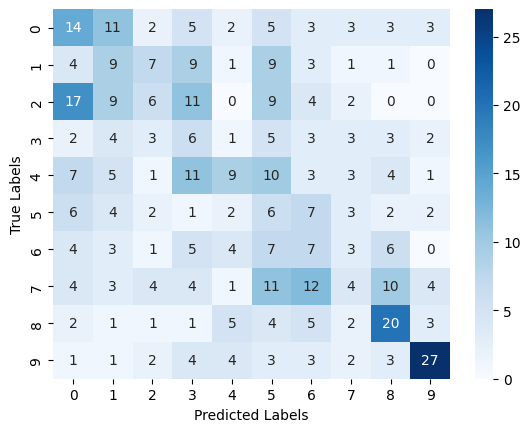

In [18]:
model_description_bow = make_pipeline(
    ColumnSelector(cols=('description'), drop_axis=True),
    CountVectorizer(),
    TfidfTransformer(),
    LogisticRegression()
)
evaluate(model_description_bow)

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.73      0.69        51
          10       0.27      0.45      0.34        44
          20       0.28      0.09      0.13        58
          30       0.14      0.19      0.16        32
          40       0.41      0.37      0.39        54
          50       0.17      0.17      0.17        35
          60       0.18      0.25      0.21        40
          70       0.36      0.14      0.20        57
          80       0.40      0.59      0.48        44
          90       0.67      0.62      0.65        50

    accuracy                           0.36       465
   macro avg       0.35      0.36      0.34       465
weighted avg       0.37      0.36      0.35       465

Confusion Matrix:



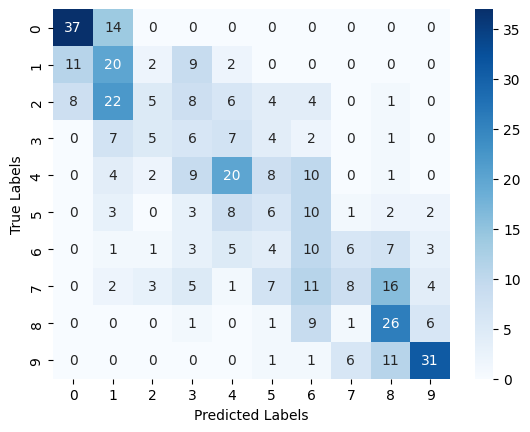

In [19]:
model_ensemble_full = StackingClassifier(
    estimators=[
      ('gb', model_gradient_boosting),
      ('rf', model_random_forest),
      ('title_bow', model_title_bow),
      ('description_bow', model_description_bow)
    ],
    final_estimator=LogisticRegression()
)

evaluate(model_ensemble_full)